In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from PIL import Image
import os, cv2,itertools

# pytorch library
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torch.nn.functional as F

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
data_dir = "../input/skin-cancer-mnist-ham10000"
print(os.listdir(data_dir))

['hmnist_28_28_L.csv', 'HAM10000_metadata.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_L.csv']


# Data analysis and preprocessing

In [30]:
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path
}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
classes = ('nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df')

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████| 10015/10015 [02:40<00:00, 62.42it/s]


(224, 224, 3, 10015)
normMean = [0.7630358, 0.54564357, 0.5700475]
normStd = [0.14092763, 0.15261263, 0.16997081]


In [5]:
df_original = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1629,HAM_0003602,ISIC_0033004,mel,histo,30.0,female,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,dermatofibroma,6
4702,HAM_0000137,ISIC_0027460,nv,follow_up,50.0,male,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4
1514,HAM_0007343,ISIC_0033831,mel,histo,70.0,male,chest,../input/skin-cancer-mnist-ham10000/ham10000_i...,dermatofibroma,6
1865,HAM_0000176,ISIC_0033696,mel,histo,65.0,male,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,dermatofibroma,6
4375,HAM_0002369,ISIC_0027016,nv,follow_up,40.0,female,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4


In [6]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3208,HAM_0004395,1,1,1,1,1,1,1,1,1
744,HAM_0001016,1,1,1,1,1,1,1,1,1
774,HAM_0001053,1,1,1,1,1,1,1,1,1
580,HAM_0000785,1,1,1,1,1,1,1,1,1
2980,HAM_0004097,1,1,1,1,1,1,1,1,1


In [7]:
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'
df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
1549,HAM_0005608,ISIC_0032903,mel,histo,75.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,dermatofibroma,6,duplicated
6370,HAM_0003440,ISIC_0026943,nv,follow_up,30.0,female,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4,unduplicated
4936,HAM_0001161,ISIC_0028691,nv,follow_up,50.0,female,abdomen,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4,unduplicated
2540,HAM_0004970,ISIC_0027774,bcc,histo,85.0,female,face,../input/skin-cancer-mnist-ham10000/ham10000_i...,Basal cell carcinoma,1,duplicated
9257,HAM_0000690,ISIC_0028586,nv,consensus,30.0,female,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,4,duplicated


In [8]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [9]:
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [10]:
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [11]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [12]:
def get_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
    
df_original['train_or_val'] = df_original['image_id']
df_original['train_or_val'] = df_original['image_id'].apply(get_val_rows)
df_train = df_original[df_original['train_or_val'] == 'train']
df_train.sample(5)
print(len(df_train))
print(len(df_val))

8912
1103


In [13]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
dermatofibroma                    1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [14]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [15]:
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [16]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

# Model building

In [17]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(64*53*53, 1024)
        self.fc2 = nn.Linear(1024, 7)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = Net()
        

In [19]:
input_size = 224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [20]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [21]:
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

#print(device)

#net.to(device)

In [24]:
print("Training started: ")
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 100 == 99:    # print every 2000 mini-batches
            print('epoch %d ===========> [%d, %3d] loss: %.3f' %
                  (epoch, epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Train started: 
epoch 0 ===========> [1, 100] loss: 1.772
epoch 0 ===========> [1, 200] loss: 1.566
epoch 0 ===========> [1, 300] loss: 1.498
epoch 0 ===========> [1, 400] loss: 1.400
epoch 0 ===========> [1, 500] loss: 1.393
epoch 0 ===========> [1, 600] loss: 1.341
epoch 0 ===========> [1, 700] loss: 1.324
epoch 0 ===========> [1, 800] loss: 1.270
epoch 0 ===========> [1, 900] loss: 1.256
epoch 0 ===========> [1, 1000] loss: 1.230
epoch 0 ===========> [1, 1100] loss: 1.213
Finished Training


In [28]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

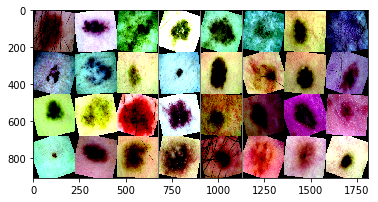

GroundTruth:  akiec akiec    df    nv


In [31]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  akiec  vasc   mel    df


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %.3f %%'% ( 100 * correct / total))

Accuracy of the network on the test images: 68.540 %


In [37]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [38]:
for i in range(7):
    print('Accuracy of %5s : %2d %%' % ( classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of    nv :  0 %
Accuracy of   mel : 75 %
Accuracy of   bkl : 44 %
Accuracy of   bcc : 100 %
Accuracy of akiec : 73 %
Accuracy of  vasc : 25 %
Accuracy of    df : 66 %
